In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from systems.long_blending import softmax
from parameters import pid_params as p_p
from stable_baselines3 import PPO

In [38]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
            ttes.append(tte)
                
        return np.array(ttes)

def toc(tte: np.ndarray):
    corridor = 2
    return len(tte[tte > corridor]) / 2

def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 0.65):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [39]:
env_selector = OctorotorEnvSelector()

pid_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':1000, 'pid_parameters':p_p()}
pid_agent = PIDAgent()


lstm_agent = PPO.load('./saved_models/higher_actions_noZ/96') 
lstm_params = {'steps_u':50, 'scaling_factor':1, 'window_distance':23, 'pid_parameters':p_p()}


lstm_params['steps_u'] = 50
lstm_params['bounding_rect_length']=1000

In [40]:
all_agents = [pid_agent, lstm_agent]
all_params = [pid_params, lstm_params]
types = ["default", "lstm"]
names = ['PID', 'RL']

In [41]:
nasa_wp = np.asarray([ # defines a real trajectory shown in a NASA paper
    [164.0146725649829, -0.019177722744643688, 30],
    [165.6418055187678, 111.5351051245816, 30],
    [127.3337449710234, 165.73576059611514, 30],
    [-187.28170707810204, 170.33217775914818, 40],
    [-192.03130502498243, 106.30660058604553, 40],
    [115.89920266153058, 100.8644210617058, 30],
    [114.81859536317643, 26.80923518165946, 30],
    [-21.459931490011513, 32.60508110653609, 30]
])

In [42]:
traj_len = 500 # trajectory seems to be around 500 seconds to complete
direction_changes = [1,2,3]
num_repeat = 25

In [43]:
def sample_wind():
    wind_vec = np.random.uniform(-10,10,2)
    mag = np.linalg.norm(wind_vec)
    
    if mag > 10:
        wind_vec = wind_vec * (10/mag)

    return wind_vec

In [44]:
# Evaluates all saved agents with their params on a wind range
def wind_injection(agents, params, types, names, traj_len, direction_changes, num_repeat):
    results = pd.DataFrame(columns=['Agent', 'Changes', 'Total TTE', 'Mean TTE', 'Completed Mission', 'Reward', 'Time Outside Corridor'])
    for num_changes in tqdm(direction_changes):
        for agent, param, env_type, name in tqdm(zip(agents, params, types, names), total=len(agents)):
            for i in range(num_repeat):

                changes_triggered = 0
                split_time = traj_len // num_changes
                random_time = int(np.random.uniform(0,split_time))
                change_time = changes_triggered * split_time + random_time
                
                env = env_selector.get_env(env_type, param, [(0,0),(0,0),(0,0)], nasa_wp, has_turbulence=True, start_alt=30)
                env.wp_options = [nasa_wp]
                env.base_env.fault_type = None
                done = False
                state = env.reset()
                state = np.array(state, dtype=np.float32)
                log = DataLog(env.base_env.vehicle, other_vars=('reward','next_wp'))
                index = 0
                while not done:
                    if index == change_time:
                        changes_triggered += 1
                        change_time = changes_triggered * split_time + random_time
                        wind_vec = sample_wind()
                        env.base_env.wind_x = wind_vec[0]
                        env.base_env.wind_y = wind_vec[1]
                        env.base_env.get_turbulence(env.base_env.prev_waypt, env.base_env.next_waypt)
                        
                    action = agent.predict(state, deterministic=True)[0] 
                    state, reward, done, info = env.step(action)
                    state = np.array(state, dtype=np.float32)
                    log.log(reward=reward, next_wp=env.base_env.next_waypt)
                    index += 1
                
                log.done_logging()
                traj_err = get_tte(log.next_wp[0], log.next_wp, log.x, log.y, log.z)
                new_result = {
                    'Agent': name,
                    'Changes': num_changes,
                    'Mean TTE': np.mean(traj_err),
                    'Total TTE': np.sum(traj_err),
                    'Completed Mission': completed_mission(nasa_wp, log.x, log.y, log.z, radius=5),
                    'Reward': np.sum(log.reward),
                    'Time Outside Corridor': toc(traj_err)
                }
                results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)

    return results

In [45]:
sample_wind()

array([-4.7565701 ,  7.58053362])

In [46]:
results = wind_injection(all_agents, all_params, types, names, traj_len, direction_changes, num_repeat)

  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_4141767/4148708439.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)
100%|██████████| 3/3 [1:23:25<00:00, 1668.39s/it]


In [47]:
results.to_csv('./data/wind_changing_turbulence.csv')

In [48]:
results = pd.read_csv('./data/wind_changing_turbulence.csv')

In [49]:
results

,Unnamed: 0,Agent,Changes,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor
0,0,PID,1,659.493366,1.796985,True,13390.3550,61.0
1,1,PID,1,602.793773,1.762555,True,13946.1310,52.0
2,2,PID,1,865.312155,2.196224,True,10384.8170,83.5
3,3,PID,1,933.527203,2.293679,True,10565.2290,83.0
4,4,PID,1,628.633495,1.770799,True,13721.2220,55.5
...,...,...,...,...,...,...,...,...
145,145,RL,3,195.763252,0.408692,True,2031.4111,0.0
146,146,RL,3,178.326598,0.385155,True,2218.4617,0.0
147,147,RL,3,185.203691,0.391551,True,2053.0710,0.0
148,148,RL,3,168.430116,0.360664,True,2308.7754,0.0


In [50]:
results[results['Agent']=='PID'].groupby(by=['Changes'])[['Total TTE', 'Mean TTE', 'Time Outside Corridor', 'Reward', 'Completed Mission']].mean()

,Total TTE,Mean TTE,Time Outside Corridor,Reward,Completed Mission
Changes,,,,,
1,654.611675,1.847046,57.74,13402.795280,1.0
2,717.286921,1.972299,61.58,12820.332760,1.0
3,748.802397,2.001222,64.20,12500.588264,1.0


In [51]:
results[results['Agent']=='PID']

,Unnamed: 0,Agent,Changes,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor
0,0,PID,1,659.493366,1.796985,True,13390.355,61.0
1,1,PID,1,602.793773,1.762555,True,13946.131,52.0
2,2,PID,1,865.312155,2.196224,True,10384.817,83.5
3,3,PID,1,933.527203,2.293679,True,10565.229,83.0
4,4,PID,1,628.633495,1.770799,True,13721.222,55.5
...,...,...,...,...,...,...,...,...
120,120,PID,3,803.820385,2.077055,True,11975.971,71.0
121,121,PID,3,884.404243,2.216552,True,11151.449,82.5
122,122,PID,3,606.041510,1.772051,True,13910.295,52.0
123,123,PID,3,542.584608,1.614835,True,14556.613,43.5


In [52]:
results[results['Agent']=='PID'].groupby(by=['Changes'])[['Total TTE', 'Mean TTE', 'Time Outside Corridor', 'Reward', 'Completed Mission']].std()

,Total TTE,Mean TTE,Time Outside Corridor,Reward,Completed Mission
Changes,,,,,
1,109.414038,0.200411,10.408450,1191.401817,0.0
2,148.363862,0.292618,12.444611,1483.020104,0.0
3,219.572910,0.383624,17.783419,2197.602378,0.0


In [53]:
results[results['Agent']=='DI-RL'].groupby(by=['Changes'])[['Total TTE', 'Mean TTE', 'Time Outside Corridor', 'Reward', 'Completed Mission']].mean()

,Total TTE,Mean TTE,Time Outside Corridor,Reward,Completed Mission
Changes,,,,,


In [54]:
results[results['Agent']=='DI-RL'].groupby(by=['Changes'])[['Total TTE', 'Mean TTE', 'Time Outside Corridor', 'Reward', 'Completed Mission']].std()

,Total TTE,Mean TTE,Time Outside Corridor,Reward,Completed Mission
Changes,,,,,


## Plots

In [55]:
filtered_results['Agent'] = filtered_results['Agent'].replace('DI-RL', 'RL-DR')

NameError: name 'filtered_results' is not defined

Text(0.5, 0, 'Number of Wind Field Changes')

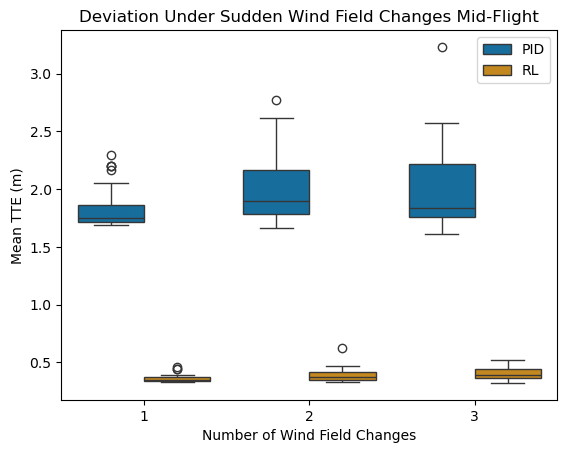

In [56]:
import seaborn as sns

plt.title("Deviation Under Sudden Wind Field Changes Mid-Flight")
# filtered_results = results[results['Agent'] == 'DI-RL']
filtered_results = results
sns.boxplot(x=filtered_results['Changes'], y=filtered_results['Mean TTE'], hue=filtered_results['Agent'], palette='colorblind')
plt.legend()
plt.ylabel("Mean TTE (m)")
plt.xlabel("Number of Wind Field Changes")